In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1)
rn.seed(1)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os, re
files = os.listdir('../input/titanic')
print(files)

# Any results you write to the current directory are saved as output.

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

['train.csv', 'gender_submission.csv', 'test.csv']


In [2]:
df_train = pd.read_csv('../input/titanic/'+files[0], engine='python')
df_test = pd.read_csv('../input/titanic/'+files[2], engine='python')
df = df_train.copy()

In [3]:
df['Title'] = df.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
df_test['Title'] = df_test.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))

In [4]:
Title_Dictionary = {
        "Capt":       "Other",
        "Col":        "Other",
        "Major":      "Other",
        "Dr":         "Mr",
        "Rev":        "Other",
        "Jonkheer":   "Other",
        "Don":        "Mr",
        "Sir" :       "Mr",
        "the Countess":"Other",
        "Dona":       "Miss",
        "Lady" :      "Miss",
        "Mme":        "Miss",
        "Ms":         "Miss",
        "Mrs" :       "Miss",
        "Mlle":       "Miss",
        "Miss" :      "Miss",
        "Mr" :        "Mr",
        "Master" :    "Mr"
                   }

df['Title'] = df.Title.map(Title_Dictionary)
df_test['Title'] = df_test.Title.map(Title_Dictionary)

In [5]:
# Train
train_y = df['Survived']
df['Sex'] = df['Sex'].astype('category').cat.codes
df['Embarked'] = df["Embarked"].replace('s', 'S')
df['Embarked'] = df["Embarked"].replace('c', 'C')
df['Embarked'] = df["Embarked"].replace('q', 'Q')
df['Embarked'] = df['Embarked'].astype('category').cat.codes
df['Title'] = df['Title'].astype('category').cat.codes

df['Cabin'] = df['Cabin'].fillna("")
df['Family_Members'] = df['Parch'] + df['SibSp']
df['Family_Numerous'] = ((df['Family_Members'] > 1) & (df['Family_Members'] < 5)).astype(int)
df['IsChild'] = (df['Age'] < 5.0).astype(int)
df['IsAlone'] = np.where((df['SibSp'] == 0) & (df['Parch'] == 0), 1, 0)
df['Age'] = df['Age'].fillna(28.80)

In [6]:
df.isna().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin              0
Embarked           0
Title              0
Family_Members     0
Family_Numerous    0
IsChild            0
IsAlone            0
dtype: int64

In [7]:
df = df.select_dtypes(exclude=['object'])
df = df.drop(["PassengerId", "Survived", "Family_Members"], axis=1)
train_x = df

In [8]:
#Test
df_test['Sex'] = df_test['Sex'].astype('category').cat.codes

df_test['Embarked'] = df_test["Embarked"].replace('s', 'S')
df_test['Embarked'] = df_test["Embarked"].replace('c', 'C')
df_test['Embarked'] = df_test["Embarked"].replace('q', 'Q')
df_test['Embarked'] = df_test['Embarked'].astype('category').cat.codes
df_test['Title'] = df_test['Title'].astype('category').cat.codes
df_test['Fare'] = df_test['Fare'].fillna(30)
df_test['Cabin'] = df_test['Cabin'].fillna("")
df_test['Family_Members'] = df_test['Parch'] + df_test['SibSp'] 
df_test['Family_Numerous'] = ((df_test['Family_Members'] > 1) & (df_test['Family_Members'] < 5)).astype(int)
df_test['IsChild'] = (df_test['Age'] < 5.0).astype(int)
df_test['IsAlone'] = np.where((df_test['SibSp'] == 0) & (df_test['Parch'] == 0), 1, 0)
df_test['Age'] = df_test['Age'].fillna(28.80)

In [9]:
df_test.isna().sum()

PassengerId        0
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin              0
Embarked           0
Title              0
Family_Members     0
Family_Numerous    0
IsChild            0
IsAlone            0
dtype: int64

In [10]:
df_test = df_test.select_dtypes(exclude=['object'])
df_test = df_test.drop(["PassengerId", "Family_Members"], axis=1)
test_x = df_test

In [11]:
sc = StandardScaler()
train_x = pd.DataFrame(sc.fit_transform(train_x.values), index=train_x.index, columns=train_x.columns)
test_x = pd.DataFrame(sc.fit_transform(test_x.values), index=test_x.index, columns=test_x.columns)
train_x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Numerous,IsChild,IsAlone
0,0.827377,0.737695,-0.578515,0.432793,-0.473674,-0.502445,0.587966,0.673537,-0.442689,-0.216803,-1.231645
1,-1.566107,-1.355574,0.652286,0.432793,-0.473674,0.786845,-1.912644,-1.313620,-0.442689,-0.216803,-1.231645
2,0.827377,-1.355574,-0.270815,-0.474545,-0.473674,-0.488854,0.587966,-1.313620,-0.442689,-0.216803,0.811922
3,-1.566107,-1.355574,0.421510,0.432793,-0.473674,0.420730,0.587966,-1.313620,-0.442689,-0.216803,-1.231645
4,0.827377,0.737695,0.421510,-0.474545,-0.473674,-0.486337,0.587966,0.673537,-0.442689,-0.216803,0.811922


In [12]:
model = Sequential()
model.add(Dense(30, 
                activation='relu',  
                input_dim=df.shape[1],
                kernel_initializer='uniform'))
model.add(Dropout(0.3))
model.add(Dense(60,
                kernel_initializer='uniform',
                activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(150,
                kernel_initializer='uniform',
                activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,
                kernel_initializer='uniform',
                activation='sigmoid'))
model.summary()

sgd = SGD(lr = 0.03, momentum = 0.95)
adam  = Adam(lr=0.0007, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# Compiling our model
model.compile(optimizer = adam, 
                   loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])
#optimizers list
#optimizers['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                360       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                1860      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 150)               9150      
_________________________________________________________________
dropout_3 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 151       
Total para

In [13]:
history = model.fit(train_x, train_y, validation_split=0.25, epochs=150, batch_size=30, verbose=1, shuffle=False)

Train on 668 samples, validate on 223 samples
Epoch 1/150
668/668 [==============================] - 1s 1ms/step - loss: 0.6913 - acc: 0.5988 - val_loss: 0.6859 - val_acc: 0.6323
Epoch 2/150
668/668 [==============================] - 0s 66us/step - loss: 0.6747 - acc: 0.6332 - val_loss: 0.6373 - val_acc: 0.8117
Epoch 3/150
668/668 [==============================] - 0s 62us/step - loss: 0.5975 - acc: 0.7814 - val_loss: 0.4878 - val_acc: 0.8251
Epoch 4/150
668/668 [==============================] - 0s 61us/step - loss: 0.4993 - acc: 0.7889 - val_loss: 0.4112 - val_acc: 0.8341
Epoch 5/150
668/668 [==============================] - 0s 61us/step - loss: 0.4638 - acc: 0.8039 - val_loss: 0.3937 - val_acc: 0.8386
Epoch 6/150
668/668 [==============================] - 0s 58us/step - loss: 0.4687 - acc: 0.8024 - val_loss: 0.3885 - val_acc: 0.8341
Epoch 7/150
668/668 [==============================] - 0s 59us/step - loss: 0.4588 - acc: 0.8054 - val_loss: 0.3826 - val_acc: 0.8386
Epoch 8/150
668/6

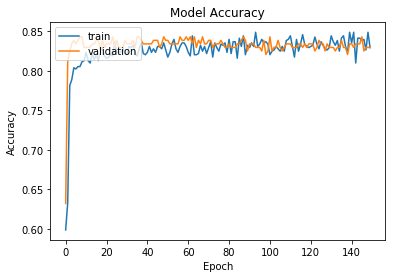

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.show()


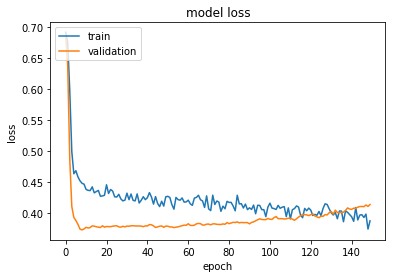

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
my_model = XGBClassifier()
my_model.fit(train_x, train_y, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

**TEST**

In [17]:
# XGBoost
predictions = my_model.predict(test_x)

In [18]:
# Keras NN

#predictions = model.predict(test_x)
#predictions = (predictions > 0.5).astype('int8')
#print(predictions[:7])

In [19]:
df_final = pd.read_csv('../input/titanic/'+files[1])
df_final['Survived'] = predictions.astype('int8')
print(df_final.head(10))

ones = list(df_final[df_final['Survived'] == 1]['PassengerId'])
print('', len(ones),'people survived out of a total of', df.shape[0], 'being the', len(ones)/df.shape[0]*100,'% of the dataset')

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0
 139 people survived out of a total of 891 being the 15.600448933782268 % of the dataset


**GRAFICOS**

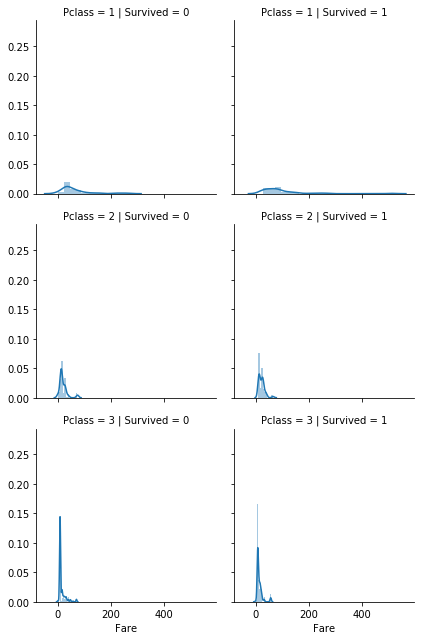

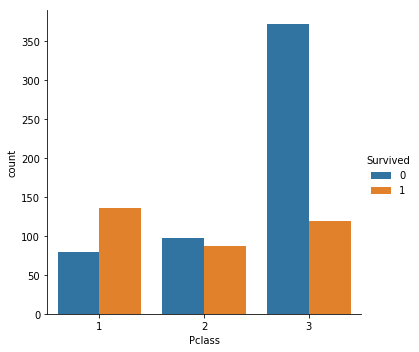

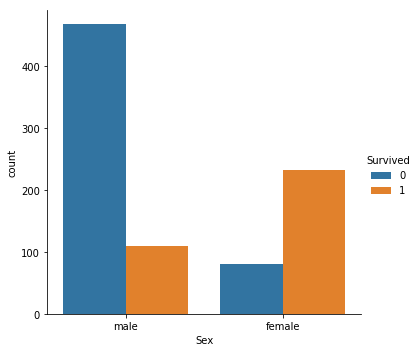

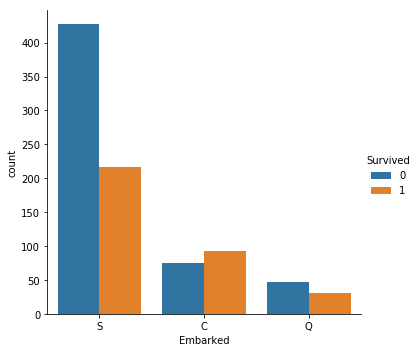

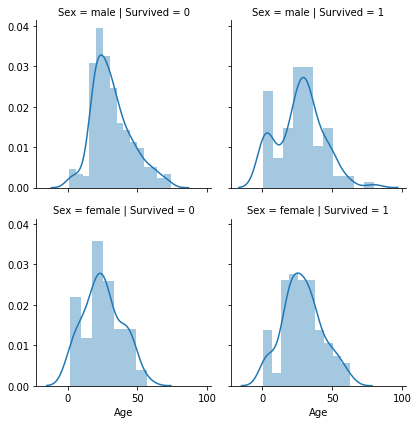

In [20]:
sns.FacetGrid(df_train, col='Survived',row='Pclass').map(sns.distplot,'Fare')
"""
sns.catplot("Family_Numerous", data=df_train, aspect=2.0, kind='count',
                       hue='Survived')
"""
sns.catplot("Pclass", data=df_train, aspect=1.0, kind='count',
                       hue='Survived')

sns.catplot("Sex", data=df_train, aspect=1.0, kind='count',
                       hue='Survived')

sns.catplot("Embarked", data=df_train, aspect=1.0, kind='count',
                       hue='Survived')

sns.FacetGrid(df_train, col='Survived',row='Sex').map(sns.distplot,'Age')

df_surv_male = []


**SAVING THE SUBMISSION TO CSV**

In [21]:
df_final.to_csv('submission.csv', index=False)